In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_02'
d = sparse_sessions[mouse][-1]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']


pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


In [3]:
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
channel_0_mask = sess.trial_info['block_number']%2==0
left_mask = sess.trial_info['LR']==-1
print(sess.trial_info['LR'],left_mask)


trial_masks['channel_0_left'] = channel_0_mask*left_mask
trial_masks['channel_0_right'] = channel_0_mask*(~left_mask)
trial_masks['channel_1_left'] = (~channel_0_mask)*left_mask
trial_masks['channel_1_right'] = (~channel_0_mask)*(~left_mask)


[ 1. -1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.
  1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1. -1.
 -1.  1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
 -1.  1. -1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1. -1.
 -1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1.] [False  True False False  True False  True  True  True  True False False
  True False  True  True False False False False  True  True  True  True
 False False  True  True False False False  True False  True  True False
 False  True  True  True False  True  True False  True False False False
  True  True False  True  True  True  True False  True  Tr

In [4]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [5]:
rng = np.random.default_rng()
nperms = 1000

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)


F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)




(1000, 30, 331)
(1000, 30, 331)
(1000, 30, 234)
(1000, 30, 234)


In [ ]:
import pickle

with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_SparseKO_02.pkl','wb') as file:
    pickle.dump(shuff_thresh,file)

In [6]:
trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_1_right'], : , :],axis=0),
              }

In [7]:
trial_means


{'channel_0_left': array([[0.05895727, 0.02713876, 0.01516355, ..., 0.04654908, 0.0244968 ,
         0.03290126],
        [0.09027454, 0.02586427, 0.02441699, ..., 0.03576738, 0.02753543,
         0.03119113],
        [0.1302681 , 0.02542327, 0.02411949, ..., 0.02929373, 0.01822475,
         0.02110288],
        ...,
        [0.04477879, 0.03099264, 0.04131224, ..., 0.04973866, 0.03770928,
         0.15505968],
        [0.04871993, 0.02800577, 0.04267294, ..., 0.06146047, 0.03763146,
         0.11053289],
        [0.04168222, 0.02394818, 0.03162088, ..., 0.06839726, 0.0400015 ,
         0.09867432]]),
 'channel_0_right': array([[0.05687147, 0.03677471, 0.02571051, ..., 0.03085737, 0.03686876,
         0.02010403],
        [0.07498406, 0.02269981, 0.04590943, ..., 0.03314604, 0.0341363 ,
         0.02180603],
        [0.14522014, 0.02139351, 0.04663346, ..., 0.03869856, 0.02219779,
         0.03652873],
        ...,
        [0.08112424, 0.01767751, 0.04344185, ..., 0.03192113, 0.0339717

In [7]:
field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

for k, thresh in shuff_thresh.items():
    print(k, thresh.shape)
    sig_bins = trial_means[k]>thresh

    # eliminate fields that start at first bin of track or end at last bin of track
    

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        # print(_redge.size)
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0) and ((_redge[0][0]+_ledge[0])<29):
        # if (_redge.shape[0]>0):
        # if (_redge.shape[0]>0):
            field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])
        

            # fig, ax = plt.subplots()
            # ax.plot(trial_means[k][:,_ledge[1]
            # if 'channel_0' in k:
            #     ax.imshow(sess.trial_matrices['channel_0_F_dff'][trial_masks[k],:, _ledge[1]])
            #     ax.plot(_ledge[0]*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            #     ax.plot((_ledge[0]+_redge[0][0])*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            # else:
            #     ax.imshow(sess.trial_matrices['channel_1_F_dff'][trial_masks[k],:, _ledge[1]])
            #     ax.plot(_ledge[0]*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            #     ax.plot((_ledge[0]+_redge[0][0])*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            # print(trial_means[k].shape)
        # ax.imshow(trial_means[k][:,_ledge[1]])

for k,v in field_info.items():
    field_info[k]=np.array(v)

channel_0_left (30, 331)
channel_0_right (30, 331)
channel_1_left (30, 234)
channel_1_right (30, 234)


(array([0.67804878, 0.25365854, 0.06829268, 0.        ]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

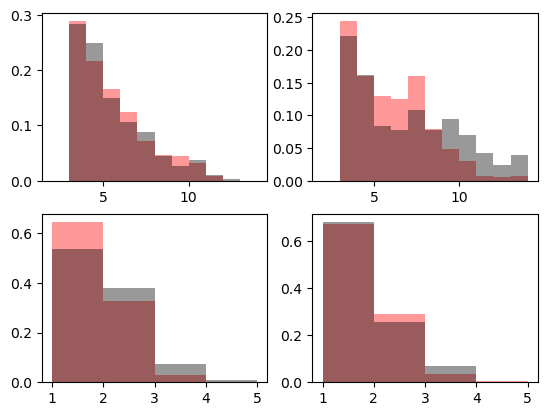

/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:7

In [8]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    